# random forest

In [1]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import torch
import torch.nn as nn

2025-01-10 10:18:55.539622: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-10 10:18:55.548328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-10 10:18:55.556903: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-10 10:18:55.559414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 10:18:55.565979: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%load_ext autoreload
%autoreload 2

## dataset

In [ ]:
# indir = '/home/yuan/results/epitope/seq_vector_1d'
# infile = os.path.join(indir, 'epitopes_15_shrink_expand.txt')
# df = pd.read_csv(infile, sep='\t', header=None, index_col=None)
# df.head()

In [57]:
infile = '/home/yuan/results/epitope/epi_comp_vector.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# df = df.iloc[:8_000_000,:]
# shuffle rows
df = df.sample(frac=1)
df['label'] = df['label'].map({'epitope':1, 'other': 0})
df.head()

,hydrophobicity_ph7,hydrophobicity,polarity,polarizability,ven_der_waals_volume,A,R,N,D,C,...,K,M,F,P,S,T,W,Y,V,label
1728135,35.000,0.789,7.993,0.133,2.943,0.067,0.000,0.067,0.067,0.000,...,0.000,0.000,0.0,0.000,0.200,0.000,0.0,0.0,0.000,1
3120714,26.778,0.734,8.539,0.140,3.043,0.167,0.111,0.000,0.000,0.000,...,0.000,0.056,0.0,0.000,0.111,0.000,0.0,0.0,0.056,0
1279349,0.600,0.777,9.367,0.127,2.775,0.333,0.000,0.000,0.000,0.000,...,0.267,0.000,0.0,0.133,0.067,0.067,0.0,0.0,0.000,1
1033612,21.438,0.980,8.281,0.135,2.891,0.062,0.000,0.000,0.062,0.000,...,0.062,0.000,0.0,0.125,0.000,0.000,0.0,0.0,0.062,1
3274362,6.333,0.580,8.600,0.119,2.698,0.000,0.000,0.000,0.000,0.111,...,0.000,0.000,0.0,0.111,0.333,0.111,0.0,0.0,0.000,0


In [56]:
# X = np.array(df.iloc[:10_000,:-1], dtype=np.float16)
# y = np.array(df.iloc[:10_000,-1], dtype=np.float16)
# print(X.shape, X.dtype, y.shape, y.dtype)

(10000, 25) float16 (10000,) float16


In [58]:
X = np.array(df.iloc[:,:-1], dtype=np.float16)
y = np.array(df.iloc[:,-1], dtype=np.float16)
print(X.shape, X.dtype, y.shape, y.dtype)

(3458238, 25) float16 (3458238,) float16


In [59]:
from collections import Counter
Counter(y)

Counter({1.0: 1865242, 0.0: 1592996})

In [60]:
# normalization X
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_X = scaler.fit_transform(X)
norm_X[:2,]

array([[ 0.84    , -0.4363  , -0.6323  , -0.673   , -0.6597  , -0.09406 ,
        -0.739   ,  0.4646  ,  0.2444  , -0.3967  ,  0.3381  , -0.792   ,
         0.00519 ,  0.9023  ,  0.284   ,  2.484   , -0.753   , -0.454   ,
        -0.6387  , -0.7085  ,  1.396   , -0.7754  , -0.3481  , -0.564   ,
        -0.863   ],
       [ 0.355   , -0.668   ,  0.012146, -0.4326  , -0.4934  ,  1.024   ,
         0.771   , -0.647   , -0.736   , -0.3967  , -0.657   ,  0.4895  ,
         0.529   ,  1.819   ,  0.119   ,  0.1487  , -0.753   ,  0.834   ,
        -0.6387  , -0.7085  ,  0.3916  , -0.7754  , -0.3481  , -0.564   ,
        -0.1342  ]], dtype=float16)

In [61]:
#split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(norm_X, y, train_size=0.7, shuffle=True, random_state=2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2420766, 25) (2420766,)
(1037472, 25) (1037472,)


## train model

In [62]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

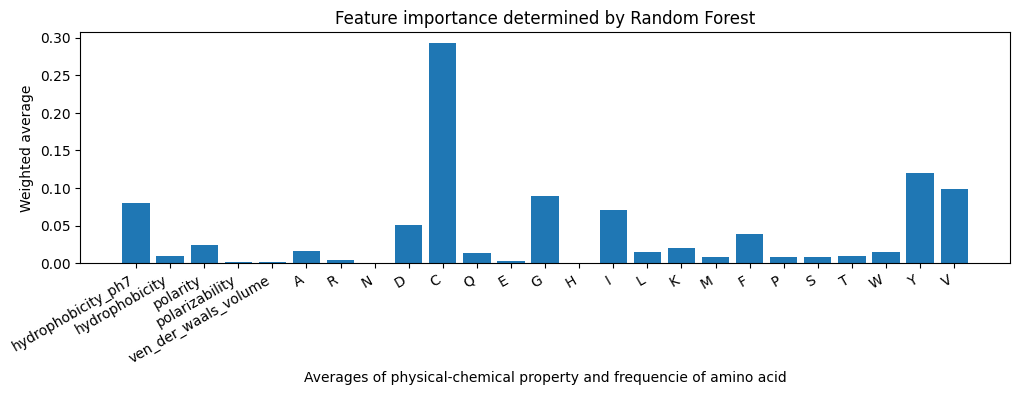

In [63]:
# feature importance
imp = pd.Series(model.feature_importances_, index = list(df)[:-1])

plt.figure(figsize=(12,3))
plt.bar(imp.index, imp)
plt.title('Feature importance determined by Random Forest')
plt.xlabel('Averages of physical-chemical property and frequencie of amino acid')
plt.ylabel('Weighted average')
# ha: horizontal alignment
plt.xticks(rotation=30, ha='right')
plt.show()

### testing

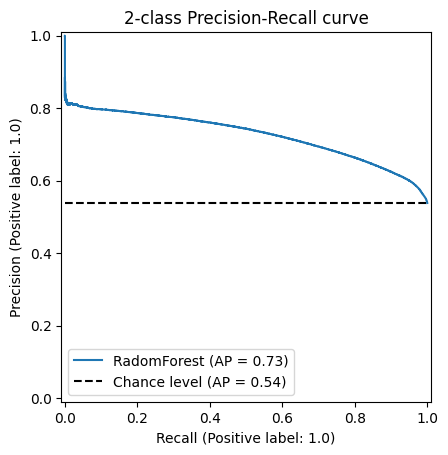

In [64]:
from sklearn.metrics import PrecisionRecallDisplay

# average precision
display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name='RadomForest', plot_chance_level=True)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [69]:
pred_test = model.predict(X_test)
pred_test[:10]

array([1., 1., 1., 0., 1., 1., 1., 0., 0., 1.], dtype=float16)

Text(0.5, 1.0, 'Prediction of non-epitopes 478874')

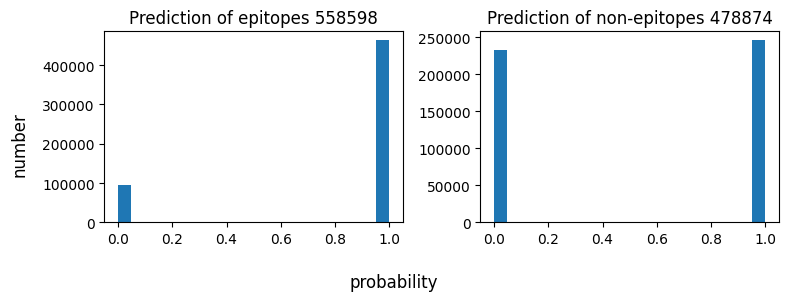

In [70]:
t = pred_test[y_test==1]
f = pred_test[y_test==0]
fig, ax = plt.subplots(1, 2, figsize=(8,3), layout='tight')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, label='True', bins=20)
ax[0].set_title(f'Prediction of epitopes {len(t)}')
ax[1].hist(f, label='False', bins=20)
ax[1].set_title(f'Prediction of non-epitopes {len(f)}')

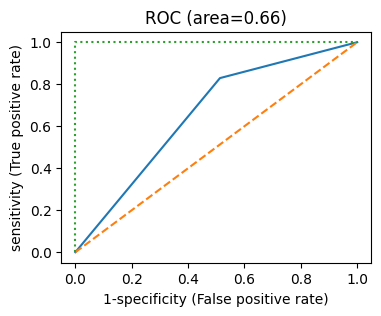

In [71]:
# ROC curve only for binary classfication
from sklearn.metrics import roc_curve, auc
# FPR, false positive rate, 1- specificity, typ I error
# TPR, true positive rate, sensitivity, power
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(fpr, tpr)
ax.set_xlabel('1-specificity (False positive rate)')
ax.set_ylabel('sensitivity (True positive rate)')
plt.title(f'ROC (area={roc_auc:.2f})')
ax.plot([0,1], [0,1], '--')
ax.plot([0,0,1], [0,1,1], ':')